## Show the number of flow records in the dataset

In [1]:
!awk 'NR > 1 { count++ } END { print "Number of lines (excluding header): " count }' datasets/dataset.csv

Number of lines (excluding header): 1360140


## Show the count of samples per application type

In [2]:
!awk -F, 'NR>1{print $(NF)}' datasets/dataset.csv | sort | uniq -c | sort -nr

384000 QUIC.YouTube
290460 TLS.TikTok
192780 TLS.Apple
108780 Discord
101400 BitTorrent
91080 QUIC.Facebook
64800 STUN
50700 HTTP
41580 SSH
34560 WhatsApp


## Encode the application labels

In [3]:
import os
import pandas as pd
import logging
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import re
from pprint import pformat

def setup_logging(log_filename = f"datasets/label-encoding.log"):
    """
    Setup the logging configuration.
    """
    # Clear the existing log file, if it exists
    with open(log_filename, 'w'):
        pass

    # Set up logging to file and console
    logging.basicConfig(level=logging.INFO,
                        force=True,
                        format='%(message)s',
                        handlers=[logging.FileHandler(log_filename), logging.StreamHandler()])

def label_mapping(input_file_name: str):
    """Function to select features."""
    
    # Read CSV file
    df = pd.read_csv(input_file_name, low_memory = False)

    # Extract filename without extension
    output_file_name, _ = os.path.splitext(input_file_name)
    
    # Create a dictionary that maps the application names to an encoding based on their frequency
    app_counts = df['application_name'].value_counts()
    encoding = {app: i for i, app in enumerate(app_counts.index)}

    # Create the reverse mapping
    reverse_encoding = {v: k for k, v in encoding.items()}

    # Log the encoding and reverse_encoding dictionaries
    logging.info(f"Label mapping:\n{pformat(encoding)}")
    logging.info(f"\nReverse label mapping:\n{pformat(reverse_encoding)}")

    # Replace the application names with the encoding
    df.loc[:, 'application_name'] = df['application_name'].map(encoding)

    df.to_csv(f"{output_file_name}_label_encoded.csv", index=False)

if __name__ == "__main__":
    
    # Call the setup_logging function
    setup_logging()

    label_mapping('datasets/dataset.csv')

Label mapping:
{'BitTorrent': 4,
 'Discord': 3,
 'HTTP': 7,
 'QUIC.Facebook': 5,
 'QUIC.YouTube': 0,
 'SSH': 8,
 'STUN': 6,
 'TLS.Apple': 2,
 'TLS.TikTok': 1,
 'WhatsApp': 9}

Reverse label mapping:
{0: 'QUIC.YouTube',
 1: 'TLS.TikTok',
 2: 'TLS.Apple',
 3: 'Discord',
 4: 'BitTorrent',
 5: 'QUIC.Facebook',
 6: 'STUN',
 7: 'HTTP',
 8: 'SSH',
 9: 'WhatsApp'}


## Plot the distribution of flows across protocols and application types via Sankey

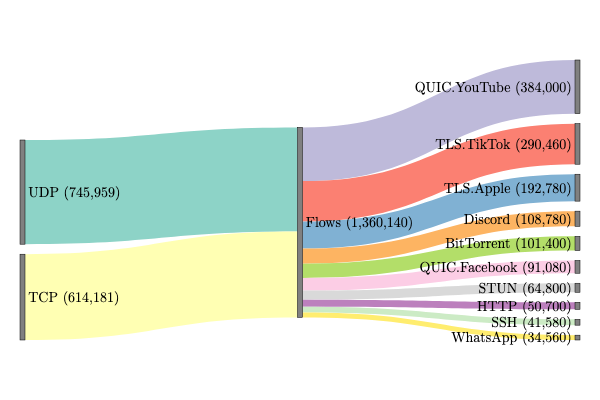

In [4]:
import os
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import plotly.offline as pyo
import seaborn as sns

pyo.init_notebook_mode(connected=True)  # Initialize the notebook mode

# Set the color palette
color_palette = px.colors.qualitative.Set3

# Read the CSV file
df = pd.read_csv('datasets/dataset_label_encoded.csv', low_memory = False)

# Replace protocol numbers with their corresponding names
df['protocol'] = df['protocol'].replace({6: 'TCP', 17: 'UDP'})

df['application_name'] = df['application_name'].replace(
{0: 'QUIC.YouTube',
 1: 'TLS.TikTok',
 2: 'TLS.Apple',
 3: 'Discord',
 4: 'BitTorrent',
 5: 'QUIC.Facebook',
 6: 'STUN',
 7: 'HTTP',
 8: 'SSH',
 9: 'WhatsApp'}
)

# Count the total number of rows and protocol distribution
total_rows = len(df)
protocol_dist = df['protocol'].value_counts()

# Initialize nodes with total flows
nodes = [dict(label=f'Flows ({total_rows:,})')]  # Include thousands separator

# Initialize links as empty list
links = []

# Create nodes and links for protocols
for i, (protocol, count) in enumerate(protocol_dist.items()):
    nodes.append(dict(label=f'{protocol} ({count:,})'))  # Include thousands separator
    links.append(dict(source=i+1, target=0, value=count, color=color_palette[i%len(color_palette)]))

# Create nodes and links for top applications
for i, (app, count) in enumerate(df['application_name'].value_counts().items()):
    nodes.append(dict(label=f'{app} ({count:,})'))  # Include thousands separator
    links.append(dict(source=0, target=i+len(protocol_dist)+1, value=count, color=color_palette[(i+len(protocol_dist))%len(color_palette)]))

# Create the Sankey diagram figure
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=10,  # Reduce padding between nodes
        thickness=5,  # Reduce node thickness
        line=dict(color='black', width=0.5),
        label=[node['label'] for node in nodes],
        color='gray'  # Change node color for better print readability
    ),
    link=dict(
        source=[link['source'] for link in links],
        target=[link['target'] for link in links],
        value=[link['value'] for link in links],
        color=[link['color'] for link in links]  # Set link color
    )
)])

# Customize the layout of the Sankey diagram
fig.update_layout(
    font=dict(
        family='CMU Serif',
        size=14,  # Reduce font size
        color='black'  # Change font color to black for better print readability
    ),
    autosize=True,  # Make the layout tight
    width=600,  # Reduce figure width
    height=400,  # Reduce figure height
    paper_bgcolor='rgba(0,0,0,0)',  # Set paper background to transparent
    plot_bgcolor='rgba(0,0,0,0)',  # Set plot background to transparent
    margin = dict(l=20, r=20, t=60, b=60)  # Reduce margins
)

# Show the plot
# pyo.iplot(fig)

# Show the plot as a static image
img_bytes = pio.to_image(fig, format='png')
from IPython.display import Image, display
display(Image(img_bytes))

# Save the Sankey diagram as a PNG file
pio.write_image(fig, f'datasets/app-distrib-sankey.png', scale=5)

## Perform feature selection

In [5]:
import os
import pandas as pd
import logging
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import re

def setup_logging(log_filename = f"datasets/feature-selection.log"):
    """
    Setup the logging configuration.
    """
    # Clear the existing log file, if it exists
    with open(log_filename, 'w'):
        pass

    # Set up logging to file and console
    logging.basicConfig(level=logging.INFO,
                        force=True,
                        format='%(message)s',
                        handlers=[logging.FileHandler(log_filename), logging.StreamHandler()])

def select_features(input_file_name: str):
    """Function to select features."""
    
    # Read CSV file
    df = pd.read_csv(input_file_name, low_memory = False)

    # Extract filename without extension
    output_file_name, _ = os.path.splitext(input_file_name)
    
    # Prepare the features, X
    X = df.loc[:, df.columns != 'application_name']

    # Prepare the target, y
    y = df['application_name']

    # Create a random forest classifier
    logging.info(f"Training RandomForestClassifier...")
    clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

    # Train the classifier
    clf.fit(X, y)
    logging.info(f"RandomForestClassifier trained\n")

    # Print the name and importance of each feature
    for feature in zip(X.columns, clf.feature_importances_):
        logging.info(f'Feature: {feature[0]}, Importance: {feature[1]}')

    # Create a selector object that will use the random forest classifier to identify
    # features that have an importance of more than a threshold
    # Adjust this threshold depending on how many features you want to keep
    logging.info(f"\nSelecting features...")
    sfm = SelectFromModel(clf, threshold=0.02)

    # Train the selector
    sfm.fit(X, y)

    # Create a dataframe for selected features
    feature_selected = []
    for feature_list_index in sfm.get_support(indices=True):
        logging.info(f'Selected feature: {X.columns[feature_list_index]}')
        feature_selected.append(X.columns[feature_list_index])
    df_selected = df.loc[:, feature_selected].copy()

    # Add back the target column
    df_selected.loc[:, 'application_name'] = df['application_name']

    logging.info(f"\nFeature selection done, {len(feature_selected)} features selected")

    df_selected.to_csv("datasets/dataset_cl.csv", index=False)

if __name__ == "__main__":
      
    # Call the setup_logging function
    setup_logging()

    select_features('datasets/dataset_label_encoded.csv')

Training RandomForestClassifier...
RandomForestClassifier trained

Feature: expiration_id, Importance: 0.007506679899613112
Feature: protocol, Importance: 0.021228729559780998
Feature: ip_version, Importance: 0.0
Feature: tunnel_id, Importance: 0.00011296473509963882
Feature: bidirectional_duration_ms, Importance: 0.015530976770129887
Feature: bidirectional_packets, Importance: 0.006878996458132033
Feature: bidirectional_bytes, Importance: 0.017431370157710756
Feature: src2dst_duration_ms, Importance: 0.014671040194140493
Feature: src2dst_packets, Importance: 0.005904407152657347
Feature: src2dst_bytes, Importance: 0.016915704393157815
Feature: dst2src_duration_ms, Importance: 0.01614409512589932
Feature: dst2src_packets, Importance: 0.008133803310976228
Feature: dst2src_bytes, Importance: 0.016922724686674176
Feature: bidirectional_min_ps, Importance: 0.051539362928836506
Feature: bidirectional_mean_ps, Importance: 0.027622300215843557
Feature: bidirectional_stddev_ps, Importance: 0.0

## Prepare IID chunks

In [6]:
import sys
import os
import pandas as pd
import logging
import argparse
from sklearn.utils import shuffle

def setup_logging(log_filename = "datasets/iid_chunks/IID-info.log"):
    with open(log_filename, 'w'):  # Use 'w' to clear the existing log file, if it exists
        pass  # Do nothing, just open and close to clear the file

    logging.basicConfig(level=logging.INFO,
                        format='%(message)s',
                        force=True,
                        handlers=[logging.FileHandler(log_filename),
                                  logging.StreamHandler()])

def iid_chunker(input_csv, num_chunks, output_dir):
    setup_logging()

    try:
        df = pd.read_csv(input_csv,low_memory=False)
        
        # Shuffle the DataFrame rows, set a seed for reproducibility
        df = shuffle(df, random_state=42)

        # Create a directory to store the output files if it doesn't already exist
        os.makedirs(output_dir, exist_ok=True)

        # Convert num_chunks to an integer
        num_chunks = int(num_chunks)

        # Create chunks
        chunks = [pd.DataFrame(columns=df.columns) for _ in range(num_chunks)]
        
#         # If residue is also needed:
#         chunks = [pd.DataFrame(columns=df.columns) for _ in range(num_chunks + 1)]

        for _, app_df in df.groupby('application_name'):
            samples_per_chunk = len(app_df) // num_chunks
            residue = len(app_df) % num_chunks

            for i in range(num_chunks):
                chunk = app_df[i * samples_per_chunk:(i + 1) * samples_per_chunk]
                chunks[i] = pd.concat([chunks[i], chunk])

#             # If there is a residue, add it to the last chunk
#             if residue > 0:
#                 chunk = app_df[-residue:]
#                 chunks[-1] = pd.concat([chunks[-1], chunk])

        # Print the distribution for each chunk and save the chunks
        for i, chunk in enumerate(chunks, start=1):
            logging.info(f"\nDistribution for Chunk {i}:\n{chunk['application_name'].value_counts().to_string(header=False)}\n")
            logging.info(f"Percentage Distribution for Chunk {i}:\n{(chunk['application_name'].value_counts(normalize=True)* 100).round(2).to_string(header=False)}\n")
            logging.info(f"Total samples in Chunk {i}: {len(chunk)}")

            # Save the chunk to a new csv file
            chunk.to_csv(os.path.join(output_dir, f'iid_chunk_{i}.csv'), index=False)

    except Exception as e:
        logging.error(f"An error occurred: {str(e)}")
        
if __name__ == "__main__":
    
    input_csv = 'datasets/dataset_cl.csv'
    num_chunks = 60
    output_dir = "datasets/iid_chunks"

    iid_chunker(input_csv, num_chunks, output_dir)


Distribution for Chunk 1:
0    6400
1    4841
2    3213
3    1813
4    1690
5    1518
6    1080
7     845
8     693
9     576

Percentage Distribution for Chunk 1:
0    28.23
1    21.36
2    14.17
3     8.00
4     7.46
5     6.70
6     4.76
7     3.73
8     3.06
9     2.54

Total samples in Chunk 1: 22669

Distribution for Chunk 2:
0    6400
1    4841
2    3213
3    1813
4    1690
5    1518
6    1080
7     845
8     693
9     576

Percentage Distribution for Chunk 2:
0    28.23
1    21.36
2    14.17
3     8.00
4     7.46
5     6.70
6     4.76
7     3.73
8     3.06
9     2.54

Total samples in Chunk 2: 22669

Distribution for Chunk 3:
0    6400
1    4841
2    3213
3    1813
4    1690
5    1518
6    1080
7     845
8     693
9     576

Percentage Distribution for Chunk 3:
0    28.23
1    21.36
2    14.17
3     8.00
4     7.46
5     6.70
6     4.76
7     3.73
8     3.06
9     2.54

Total samples in Chunk 3: 22669

Distribution for Chunk 4:
0    6400
1    4841
2    3213
3    1813
4    1690

Total samples in Chunk 27: 22669

Distribution for Chunk 28:
0    6400
1    4841
2    3213
3    1813
4    1690
5    1518
6    1080
7     845
8     693
9     576

Percentage Distribution for Chunk 28:
0    28.23
1    21.36
2    14.17
3     8.00
4     7.46
5     6.70
6     4.76
7     3.73
8     3.06
9     2.54

Total samples in Chunk 28: 22669

Distribution for Chunk 29:
0    6400
1    4841
2    3213
3    1813
4    1690
5    1518
6    1080
7     845
8     693
9     576

Percentage Distribution for Chunk 29:
0    28.23
1    21.36
2    14.17
3     8.00
4     7.46
5     6.70
6     4.76
7     3.73
8     3.06
9     2.54

Total samples in Chunk 29: 22669

Distribution for Chunk 30:
0    6400
1    4841
2    3213
3    1813
4    1690
5    1518
6    1080
7     845
8     693
9     576

Percentage Distribution for Chunk 30:
0    28.23
1    21.36
2    14.17
3     8.00
4     7.46
5     6.70
6     4.76
7     3.73
8     3.06
9     2.54

Total samples in Chunk 30: 22669

Distribution for Chunk 31:
0    6

Percentage Distribution for Chunk 54:
0    28.23
1    21.36
2    14.17
3     8.00
4     7.46
5     6.70
6     4.76
7     3.73
8     3.06
9     2.54

Total samples in Chunk 54: 22669

Distribution for Chunk 55:
0    6400
1    4841
2    3213
3    1813
4    1690
5    1518
6    1080
7     845
8     693
9     576

Percentage Distribution for Chunk 55:
0    28.23
1    21.36
2    14.17
3     8.00
4     7.46
5     6.70
6     4.76
7     3.73
8     3.06
9     2.54

Total samples in Chunk 55: 22669

Distribution for Chunk 56:
0    6400
1    4841
2    3213
3    1813
4    1690
5    1518
6    1080
7     845
8     693
9     576

Percentage Distribution for Chunk 56:
0    28.23
1    21.36
2    14.17
3     8.00
4     7.46
5     6.70
6     4.76
7     3.73
8     3.06
9     2.54

Total samples in Chunk 56: 22669

Distribution for Chunk 57:
0    6400
1    4841
2    3213
3    1813
4    1690
5    1518
6    1080
7     845
8     693
9     576

Percentage Distribution for Chunk 57:
0    28.23
1    21.36
2    14

## Plot application distribution in IID chunks

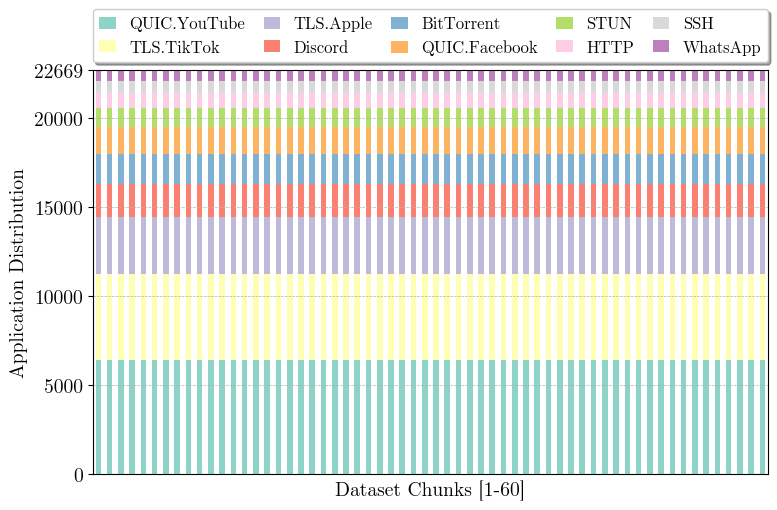

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted

# Set the font family and size
plt.rcParams['font.family'] = 'CMU Serif'
plt.rcParams['font.size'] = 14

# Set the Seaborn color palette
sns.set_palette('Set3')

# Label mapping
mapping = {0: 'QUIC.YouTube',
           1: 'TLS.TikTok',
           2: 'TLS.Apple',
           3: 'Discord',
           4: 'BitTorrent',
           5: 'QUIC.Facebook',
           6: 'STUN',
           7: 'HTTP',
           8: 'SSH',
           9: 'WhatsApp'}

# Specify the subfolder
subfolder = 'datasets/iid_chunks'

# Get all CSV files in the subfolder
csv_files = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.endswith('.csv')]

# Sort the files alphabetically
csv_files = natsorted(csv_files)

# Initialize an empty DataFrame to hold all the value counts
all_counts = pd.DataFrame()

# Initialize a variable to hold the maximum value count
max_value_count = 0

for idx, file in enumerate(csv_files):
    # Load the CSV data
    df = pd.read_csv(file, low_memory=False)

    # Check if 'application_name' is in dataframe columns
    if 'application_name' in df.columns:
        # Replace encoded values with their respective application names
        df['application_name'].replace(mapping, inplace=True)

        # Get value counts for 'application_name'
        app_counts = df['application_name'].value_counts()

        # Update the maximum value count if necessary
        max_value_count = max(max_value_count, app_counts.sum())

        # Convert the value counts to a DataFrame and transpose it
        app_counts_df = pd.DataFrame(app_counts).T

        # Change the index to the file number
        app_counts_df.index = [idx+1]  # make index 1-based

        # Append the value counts to the all_counts DataFrame
        all_counts = pd.concat([all_counts, app_counts_df])
    else:
        print(f"'application_name' column not found in {file}")

# Create the stacked bar plot
ax = all_counts.plot(kind='bar', stacked=True, figsize=(8, 5.33))

# Set the y-axis limit slightly above the maximum value count
ax.set_ylim([0, max_value_count])

# Set the y-axis ticks excluding the extended y-axis limit
ax.set_yticks(list(filter(lambda x: x <= max_value_count, ax.get_yticks())) + [max_value_count])

# Set the legend title and place it above the plot
ax.legend(
    #title='Application Type'
           bbox_to_anchor=(0., 1.02, 1., .102)
          , loc='lower left'
          , ncol=5
          , mode="expand"
          , borderaxespad=0.
          , fancybox=True
          , shadow=True
          , prop={'size': 12}
          , handlelength=1  # Adjust this value to reduce or increase the bar width
          )

# Set the x and y axis titles
ax.set_xlabel('Dataset Chunks [1-60]')
ax.set_ylabel('Application Distribution')

# Remove x-axis ticks and labels
ax.set_xticks([])
ax.set_xticklabels([])

# Customize the grid lines
ax.grid(axis='y', linestyle='--', linewidth=0.5)

# Set plot layout to be compact
plt.tight_layout()

# Save the plot
plt.savefig('datasets/iid_chunks/iid_distribution.png', dpi=300)

# Optionally show the plot
plt.show()

## Prepare non-IID chunks

In [8]:
import pandas as pd
import logging
from sklearn.utils import shuffle
import argparse
import numpy as np
import random
import os

np.random.seed(42)  # set a seed for numpy
random.seed(42)  # set a seed for python built-in random

def setup_logging(log_filename = "datasets/non_iid_chunks/non-IID-info.log"):
    with open(log_filename, 'w'):  # Use 'w' to clear the existing log file, if it exists
        pass  # Do nothing, just open and close to clear the file

    logging.basicConfig(level=logging.INFO,
                        format='%(message)s',
                        force=True,
                        handlers=[logging.FileHandler(log_filename),
                                  logging.StreamHandler()])

def chunk_dataframe(df, num_chunks):
    available_apps = df['application_name'].unique().tolist()

    chunks = []
    ideal_chunk_size = len(df) // num_chunks
    min_samples_per_chunk = round(ideal_chunk_size * 0.7)  # 30% less
    max_samples_per_chunk = round(ideal_chunk_size * 1.3)  # 30% more

    # Get the overall distribution of the 'application_name' in the input CSV
    app_distribution = df['application_name'].value_counts(normalize=True)

    uniform_chunks_indexes = range(6, num_chunks+1, 6) # 6th, 12th, 18th, ... chunks

    # Create uniformly distributed chunks first
    for i in uniform_chunks_indexes:
        chunk = pd.DataFrame()
        for app in available_apps:
            app_df = df[df['application_name'] == app]
            samples_to_add = int(app_distribution[app] * ideal_chunk_size)
            samples_to_add = min(samples_to_add, len(app_df))
            sample_df = app_df.sample(n=samples_to_add, replace=False)
            df = df.drop(sample_df.index)
            chunk = pd.concat([chunk, sample_df])
        chunks.append((i, chunk))

    total_remaining_samples = len(df)
    non_iid_chunks_sizes = []
    while total_remaining_samples > max_samples_per_chunk:
        chunk_size = random.randint(min_samples_per_chunk, max_samples_per_chunk)
        non_iid_chunks_sizes.append(chunk_size)
        total_remaining_samples -= chunk_size
    non_iid_chunks_sizes.append(total_remaining_samples) # Add the rest to the last non-IID chunk

    # Create non-IID chunks for the rest
    non_iid_chunk_index = 0
    for i in range(1, num_chunks + 1):
        if i in uniform_chunks_indexes: # If it's a uniformly distributed chunk, skip
            continue
        # If df is empty, break the loop
        if df.empty:
            print(f"DataFrame is empty after creating {i-1} chunks.")
            break

        chunk = pd.DataFrame()
        remaining_apps = df['application_name'].unique().tolist()
        random.shuffle(remaining_apps)

        max_samples_for_this_chunk = non_iid_chunks_sizes[non_iid_chunk_index]
        non_iid_chunk_index += 1

        for app in remaining_apps:
            app_df = df[df['application_name'] == app]
            remaining_space = max_samples_for_this_chunk - len(chunk)
            upper_bound = min(remaining_space, len(app_df))
            if upper_bound <= 0:
                continue
            samples_to_add = random.randint(1, upper_bound)
            sample_df = app_df.sample(n=samples_to_add, replace=False)
            df = df.drop(sample_df.index)
            chunk = pd.concat([chunk, sample_df])
            if len(chunk) >= max_samples_for_this_chunk:
                break
        chunks.append((i, chunk))

    # Sort chunks based on their index
    chunks.sort(key=lambda x: x[0])

    # Distribute remaining samples in df to the 10 non-uniform chunks with least samples
    non_uniform_chunks = [(i, chunk) for i, chunk in chunks if i not in uniform_chunks_indexes]
    remaining_samples_per_chunk = len(df) // 10

    while not df.empty:
        non_uniform_chunks.sort(key=lambda x: len(x[1]), reverse=False)  # sort chunks by size
        for idx, (index, chunk) in enumerate(non_uniform_chunks[:10]):  # take 10 chunks with least samples
            if df.empty:
                break
            sample_df = df.sample(n=min(remaining_samples_per_chunk, len(df)), replace=False)  # get samples
            df = df.drop(sample_df.index)
            chunk = pd.concat([chunk, sample_df])
            non_uniform_chunks[idx] = (index, chunk)  # Update the chunk

    # Replace the non_uniform_chunks back to the main chunks list
    for index, chunk in non_uniform_chunks:
        chunks[index-1] = (index, chunk)  # Index in chunks list is 0-based

    
    # Return only chunk data
    chunks = [chunk for index, chunk in chunks]

    return chunks

def non_iid_chunker(input_csv, num_chunks, shuffle_option, output_dir):

    setup_logging()

    try:
        df = pd.read_csv(input_csv, low_memory=False)
        
        # Convert num_chunks to an integer
        num_chunks = int(num_chunks)
             
        # Create a directory to store the output files if it doesn't already exist
        os.makedirs(output_dir, exist_ok=True)
        
        if shuffle_option:
            df = shuffle(df, random_state=42)

        chunks = chunk_dataframe(df, num_chunks)
        
        # Print the distribution for each chunk and save the chunks
        for i, chunk in enumerate(chunks, start=1):
            logging.info(f"\nDistribution for Chunk {i}:\n{chunk['application_name'].value_counts().to_string(header=False)}\n")
            logging.info(f"Percentage Distribution for Chunk {i}:\n{(chunk['application_name'].value_counts(normalize=True)* 100).round(2).to_string(header=False)}\n")
            logging.info(f"Total samples in Chunk {i}: {len(chunk)}")

            # Save the chunk to a new csv file
            chunk.to_csv(os.path.join(output_dir, f'non_iid_chunk_{i}.csv'), index=False)

    except Exception as e:
        logging.error(f"An error occurred: {str(e)}")
        

if __name__ == "__main__":
        
    input_csv = 'datasets/dataset_cl.csv'
    num_chunks = 60
    shuffle_option = True
    output_dir = "datasets/non_iid_chunks"

    non_iid_chunker(input_csv, num_chunks, shuffle_option, output_dir)


Distribution for Chunk 1:
3    17572
4     3101
0     2262
7     2046
2      601
9      425
8      323
1       11
6        3

Percentage Distribution for Chunk 1:
3    66.70
4    11.77
0     8.59
7     7.77
2     2.28
9     1.61
8     1.23
1     0.04
6     0.01

Total samples in Chunk 1: 26344

Distribution for Chunk 2:
7    6228
2    3715
0    3310
5    2278
8    1495
4     190
6     182
9     167
1      86
3      27

Percentage Distribution for Chunk 2:
7    35.23
2    21.01
0    18.72
5    12.89
8     8.46
4     1.07
6     1.03
9     0.94
1     0.49
3     0.15

Total samples in Chunk 2: 17678

Distribution for Chunk 3:
8    10486
0     5629
4     4423
1     3685
3     1141
7       84
5       57
9       30
6       21
2        3

Percentage Distribution for Chunk 3:
8    41.03
0    22.02
4    17.31
1    14.42
3     4.46
7     0.33
5     0.22
9     0.12
6     0.08
2     0.01

Total samples in Chunk 3: 25559

Distribution for Chunk 4:
8    14495
4    12965
5      470
2       34
7      

Total samples in Chunk 27: 25505

Distribution for Chunk 28:
1    15375
0     9705
5      447
3       35
9       17
6       11
4        3
7        1
2        1

Percentage Distribution for Chunk 28:
1    60.07
0    37.92
5     1.75
3     0.14
9     0.07
6     0.04
4     0.01
7     0.00
2     0.00

Total samples in Chunk 28: 25595

Distribution for Chunk 29:
0    23585
6     1039
1      210
3      159
2       42
4       10
5        9
7        4
9        3

Percentage Distribution for Chunk 29:
0    94.11
6     4.15
1     0.84
3     0.63
2     0.17
4     0.04
5     0.04
7     0.02
9     0.01

Total samples in Chunk 29: 25061

Distribution for Chunk 30:
0    6400
1    4841
2    3213
3    1813
4    1690
5    1518
6    1080
7     845
8     693
9     576

Percentage Distribution for Chunk 30:
0    28.23
1    21.36
2    14.17
3     8.00
4     7.46
5     6.70
6     4.76
7     3.73
8     3.06
9     2.54

Total samples in Chunk 30: 22669

Distribution for Chunk 31:
2    13307
3     4489
6      6

## Plot application distribution in non-IID chunks

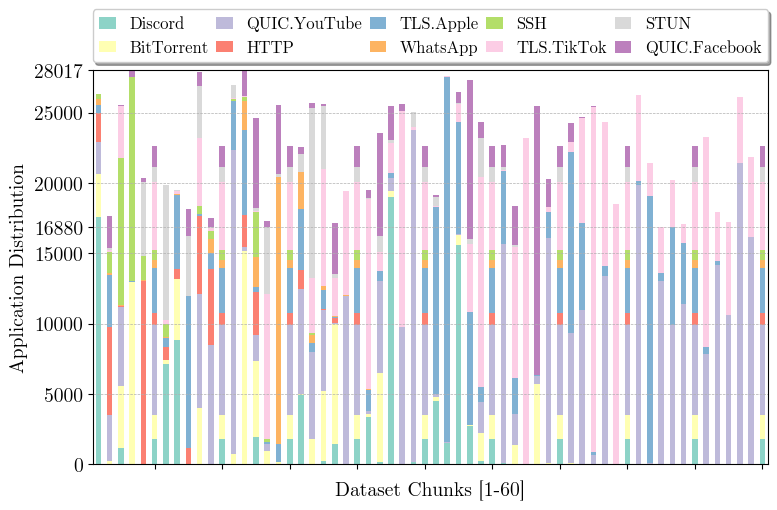

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted

# Set the font family and size
plt.rcParams['font.family'] = 'CMU Serif'
plt.rcParams['font.size'] = 14

# Set the Seaborn color palette
sns.set_palette('Set3')

# Label mapping
mapping = {0: 'QUIC.YouTube',
           1: 'TLS.TikTok',
           2: 'TLS.Apple',
           3: 'Discord',
           4: 'BitTorrent',
           5: 'QUIC.Facebook',
           6: 'STUN',
           7: 'HTTP',
           8: 'SSH',
           9: 'WhatsApp'}

# Specify the subfolder
subfolder = 'datasets/non_iid_chunks'

# Get all CSV files in the subfolder
csv_files = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.endswith('.csv')]

# Sort the files alphabetically
csv_files = natsorted(csv_files)

# Initialize an empty DataFrame to hold all the value counts
all_counts = pd.DataFrame()


# Initialize a variable to hold the minimum value count
min_value_count = None

# Initialize a variable to hold the maximum value count
max_value_count = 0

for idx, file in enumerate(csv_files):
    # Load the CSV data
    df = pd.read_csv(file, low_memory=False)

    # Check if 'application_name' is in dataframe columns
    if 'application_name' in df.columns:
        # Replace encoded values with their respective application names
        df['application_name'].replace(mapping, inplace=True)

        # Get value counts for 'application_name'
        app_counts = df['application_name'].value_counts()
        
        total_count = app_counts.sum()
    
        # Update the minimum value count if necessary
        if min_value_count is None or total_count < min_value_count:
            min_value_count = total_count
        
        # Update the maximum value count if necessary
        if total_count > max_value_count:
            max_value_count = total_count

        # Convert the value counts to a DataFrame and transpose it
        app_counts_df = pd.DataFrame(app_counts).T

        # Change the index to the file number
        app_counts_df.index = [idx+1]  # make index 1-based

        # Append the value counts to the all_counts DataFrame
        all_counts = pd.concat([all_counts, app_counts_df])
    else:
        print(f"'application_name' column not found in {file}")

# Create the stacked bar plot for all data
ax1 = all_counts.plot(kind='bar', stacked=True, figsize=(8, 5.33))

# Set the y-axis ticks to include the minimum and maximum value counts
ax1.set_yticks(list(filter(lambda x: x <= max_value_count, ax1.get_yticks())) + [min_value_count, max_value_count])

# Sort the y-ticks
ax1.yaxis.set_major_locator(plt.FixedLocator(sorted(ax1.get_yticks())))

# Set the y-axis limit slightly above the maximum value count
ax1.set_ylim([0, max_value_count])

# Set the legend title and place it above the plot
ax1.legend(
    #title='Application Type'
           bbox_to_anchor=(0., 1.02, 1., .102)
          , loc='lower left'
          , ncol=5
          , mode="expand"
          , borderaxespad=0.
          , fancybox=True
          , shadow=True
          , prop={'size': 12}
          , handlelength=1  # Adjust this value to reduce or increase the bar width
          )

# Set the x and y axis titles
ax1.set_xlabel('Dataset Chunks [1-60]')
ax1.set_ylabel('Application Distribution')

# Remove x-axis ticks and labels
ax1.set_xticks([5,11,17,23,29,35,41,47,53,59])
ax1.set_xticklabels([])

# Customize the grid lines
ax1.grid(axis='y', linestyle='--', linewidth=0.5)

# Set plot layout to be compact
plt.tight_layout()

# Save the plot
plt.savefig('datasets/non_iid_chunks/non_iid_distribution.png', dpi=300)

plt.show()